# San Francisco Parking Exploratory Data Analysis
this notebook is for the in depth analyis of the San Francisco Parking Ticket data. The main goal of this will be to answer four questions. 

1. Can we identify streets that are less likely for enforcement officer to travel through, when looking for residential overtime tickets?

2. How long can we expect to park before we have to move our car?

3. Which hour of street cleaning is most effective at getting people ticketed?

4. Does less frequent street cleaning get mroe tickets per sweep?




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import datetime as dt
import time
from scipy import stats
import sqlite3
import math
import seaborn as sns
import statsmodels.formula as sm
import scipy 
import pickle
import matplotlib as mpl
%matplotlib inline

mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['figure.autolayout'] = True
mpl.rc('xtick', labelsize = 8)

In [2]:
def result_query(querystring):
    resultdf = pd.read_sql(sql= querystring, con = conn)
    
    return resultdf

In [3]:
project_folder = '/home/colin/Desktop/SF_Parking/'
raw_folder = project_folder + 'data/raw/'
proc_folder = project_folder + 'data/processed/'
image_folder = project_folder + 'reports/figures/analysis/'

In [4]:
conn = sqlite3.connect(proc_folder + 'SF_Parking.db')
c = conn.cursor()
tables = result_query("SELECT name FROM sqlite_master where type = 'table'")
tables

,name
0,raw_ticket_data
1,raw_address_data
2,single_address
3,ticket_data
4,street_sweep_data
5,address_data
6,street_volume_data


# Theory
Let's test our initial hypothesis, but include street parking availability now. We'll also include some more noise reduction this time aorund. 

In [5]:
#Lets categorize addresses by our street volume, not including zero volume streets or those in neighborhoods without res OT
streets = result_query("Select distinct t3.lineid, t3.streetname, nhood, distance, total_ea, vvol_carea, vvol_trkea, vvol_busea, speed_ea, oneway, count(*) total_tickets, park_supply "
                       'from ticket_data t1 join address_data t2 on t1.address = t2.address ' 
                       ' join street_volume_data t3 on t2.lineid = t3.lineid '
                       " Where ViolationDesc = 'RES/OT' and nhood not in ('Tenderloin', 'Financial District/South Beach') and total_ea > 0 group by t3.lineid")
c.execute('Select Max(TickIssueDate), Min(TickIssueDate) from ticket_data')
totaldays = c.fetchone()
maxdate = time.strptime( totaldays[0], '%Y-%m-%d %H:%M:%S')
mindate = time.strptime( totaldays[1], '%Y-%m-%d %H:%M:%S')
totaldays = (time.mktime(maxdate) - time.mktime(mindate)) / (60*60*24)
totalyears = totaldays / 365

In [6]:
totalyears

2.1698249619482497

Let's create a few new columns and fill in some bad records. First Let's fix the parking supply column. If anyone got a residential overtime spot, there was clearly some parking available. Let's use the neighborhood average spots per mile to fill this in where its null or 0. 

In [7]:
streets['parkpermile'] = streets['park_supply'] / streets['distance']
streets_mean = streets[streets.park_supply > 0 ].groupby(by = ['nhood'], as_index = False)['parkpermile'].mean()
streets_1 = streets[streets.park_supply > 0 ]
streets_2 = streets[(streets.park_supply== 0) | (pd.isnull(streets.park_supply)) ]
streets_2 = streets_2.merge(streets_mean, left_on = 'nhood', right_on = 'nhood')

In [8]:
print(streets_1.shape)
print(streets_2.shape)

(1790, 13)
(1116, 14)


In [9]:
streets_2['park_supply'] = streets_2['parkpermile_y'] * streets_2['distance']
streets_2.rename(columns = {'parkpermile_y':'parkpermile'}, inplace = True)
streets_2.drop(columns =['parkpermile_x'], inplace = True)
streets = streets_1.append(streets_2)

In [10]:
#to avoid any problems log transforming, we'll add 1 to all street volume(avoiding decimals)
streets['total_ea'] = streets['total_ea']+1

#Lets remove some of the streets with only 1 ticket
streets = streets[streets.total_tickets > 1]


/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Total Tickets')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


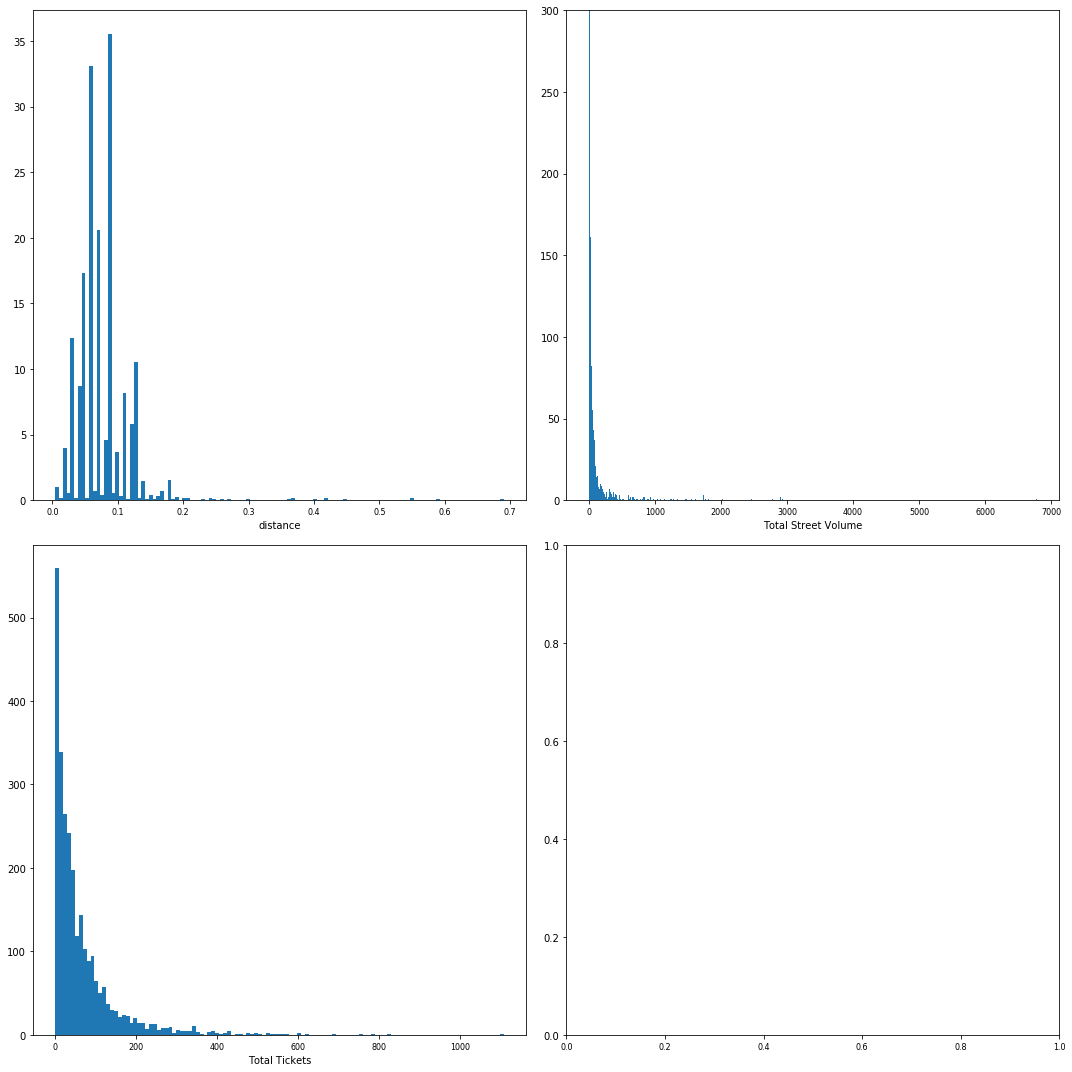

In [11]:
import matplotlib.pyplot as plt 
fig, axplots = plt.subplots(2,2, figsize = (15, 15))

axplots[0,0].hist(streets.distance, bins = 'auto', normed = True)
axplots[0,0].set_xlabel('distance')

axplots[0,1].hist(streets.total_ea, bins = 'auto')
axplots[0,1].set_xlabel('Total Street Volume')
axplots[0,1].set_ylim(0,300)

axplots[1,0].hist(streets.total_tickets, bins = 'auto' )
axplots[1,0].set_xlabel('Total Tickets')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes

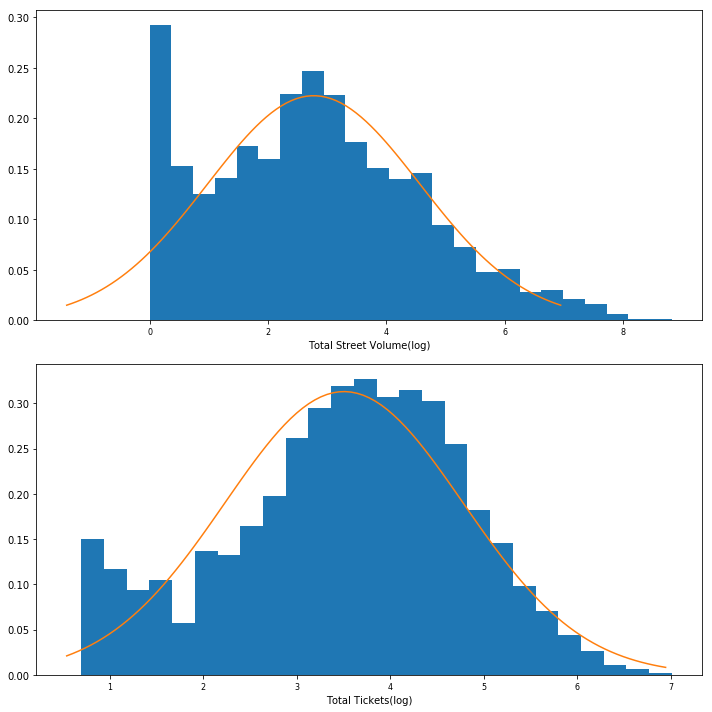

In [12]:
#Lets Log Transform a few to see if they appear a little more normal
from scipy.stats import norm

fig, axplots = plt.subplots(2, figsize = (10, 10))
log_volume = np.log(streets['total_ea'])
log_tickets = np.log(streets['total_tickets'])
vol_mean = log_volume.mean()
tick_mean = log_tickets.mean()
vol_std = log_volume.std()
tick_std = log_tickets.std()
vol_normals = norm(loc = vol_mean, scale = vol_std)
vol = np.linspace(vol_normals.ppf(0.01), 
                        vol_normals.ppf(0.99), 100)

tick_normals = norm(loc = tick_mean, scale = tick_std)
ticks = np.linspace(tick_normals.ppf(0.01), 
                        vol_normals.ppf(0.99), 
                        100)


axplots[0].hist(log_volume, bins = 'auto', normed = True )
axplots[0].set_xlabel('Total Street Volume(log)')
axplots[0].plot(vol, vol_normals.pdf(vol))

axplots[1].hist(np.log(streets.total_tickets), bins = 'auto', normed = True )
axplots[1].set_xlabel('Total Tickets(log)')
axplots[1].plot(ticks, tick_normals.pdf(ticks))
plt.savefig(image_folder + 'model/streetnormality.png')

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Cumulative Distribution of Street Volume')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


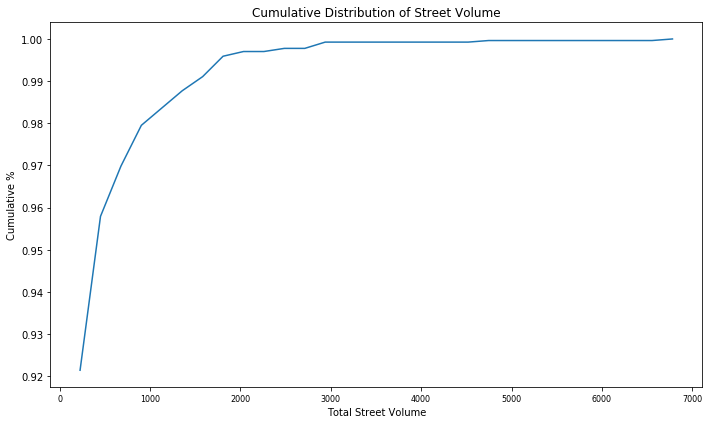

In [13]:
#Lets look at the percentiles of streetvolume
plt.figure(figsize = (10,6))
counts, bin_edges = np.histogram(streets['total_ea'], bins=30, normed=True)
cdf = np.cumsum (counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('Total Street Volume')
plt.ylabel('Cumulative %')
plt.title('Cumulative Distribution of Street Volume')




In [14]:
for q in [25, 50, 75, 100]:
    print ("{}%% percentile: {}".format (q, np.percentile(streets['total_ea'], q)))

25%% percentile: 4.031000000000001
50%% percentile: 14.625290000000001
75%% percentile: 54.228359999999995
100%% percentile: 6780.86341


/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


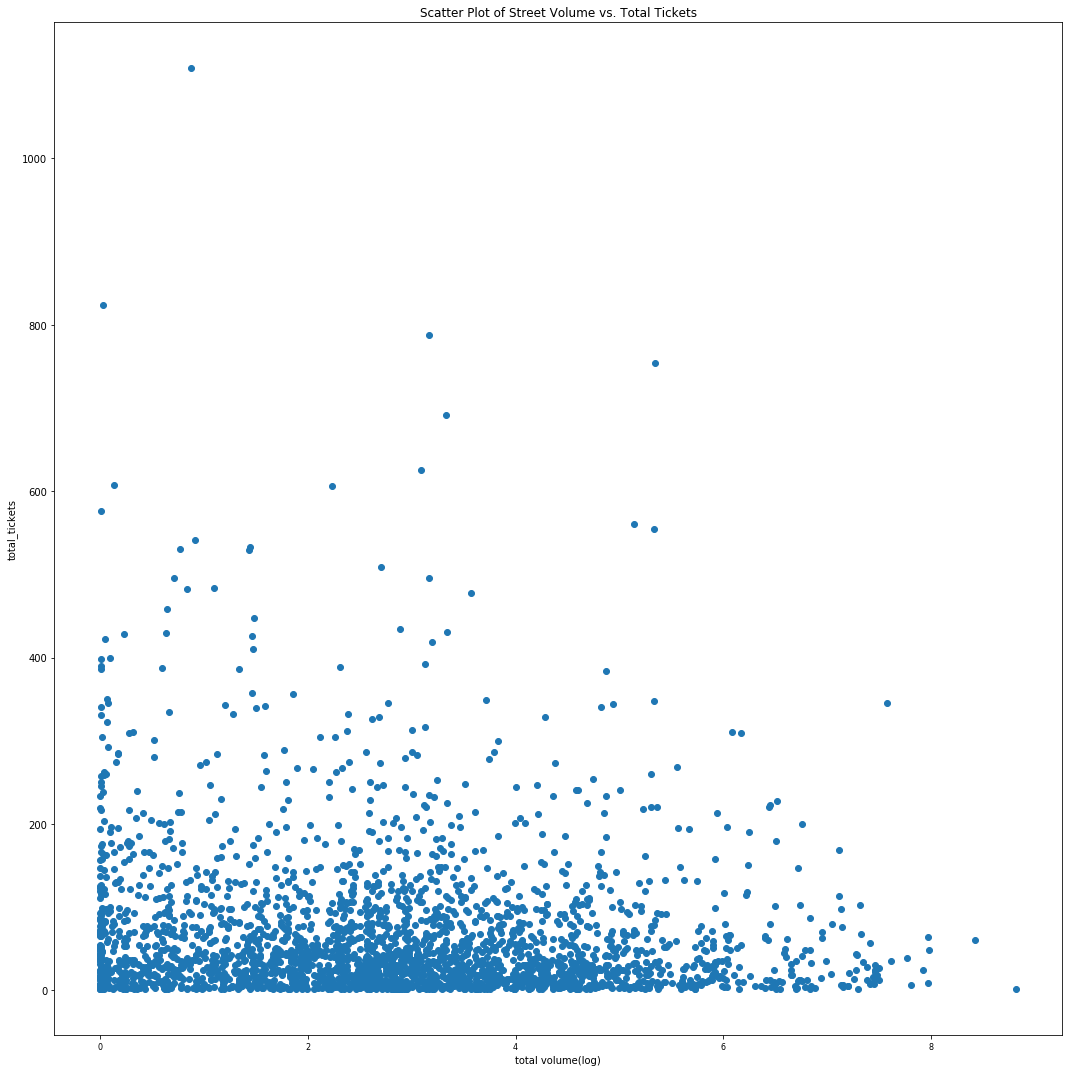

In [15]:
# Lets scatter volume against total tickets

plt.figure(figsize = (15, 15))
plt.scatter(x = np.log(streets['total_ea']), y = streets['total_tickets'])
plt.xlabel('total volume(log)')
plt.ylabel('total_tickets')
plt.title('Scatter Plot of Street Volume vs. Total Tickets')
plt.savefig(image_folder + 'model/volvstix.png')

In [16]:
# Lets do the same, but create a new measure, tickets per 100 parking spaces 
streets['tickperspot'] = streets['total_tickets'] / (streets['park_supply'] / 100) / totalyears
streets[streets.park_supply < 5]

,lineid,streetname,nhood,distance,total_ea,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,total_tickets,park_supply,parkpermile,tickperspot
28,30918,COSO,Bernal Heights,0.02000,11.91166,10.85492,0.05674,0.0,16.66667,0,13,3.000000,150.000000,199.708889
95,32586,ROUSSEAU,Outer Mission,0.04000,37.57893,36.11652,0.46241,0.0,16.66667,1,2,2.000000,50.000000,46.086667
135,32867,CHENERY,Glen Park,0.02000,11.72036,10.53533,0.18503,0.0,16.66667,0,20,4.000000,200.000000,230.433334
144,32936,SURREY,Glen Park,0.01000,9.34461,8.21450,0.13011,0.0,16.66667,0,14,1.000000,100.000000,645.213335
154,33266,CAYUGA,Outer Mission,0.04000,1.69012,0.68750,0.00262,0.0,16.66667,0,53,3.000000,75.000000,814.197780
259,34715,SOUTHWOOD,West of Twin Peaks,0.03000,1.25175,0.24331,0.00844,0.0,16.66667,0,154,4.000000,133.333333,1774.336671
261,34745,MIRAMAR,Oceanview/Merced/Ingleside,0.05000,32.34275,30.67835,0.66440,0.0,16.66667,0,114,3.000000,60.000000,1751.293338
317,35492,CLAREMONT,West of Twin Peaks,0.06000,194.05082,181.93037,5.12045,6.0,19.42865,0,62,3.000000,50.000000,952.457780
326,35537,MAGELLAN,West of Twin Peaks,0.05000,10.80669,9.47994,0.32675,0.0,16.66667,0,16,3.000000,60.000000,245.795556
477,36321,SLOAT,Sunset/Parkside,0.06000,49.61641,39.17471,0.44170,9.0,19.44444,1,3,4.000000,66.666667,34.565000


/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


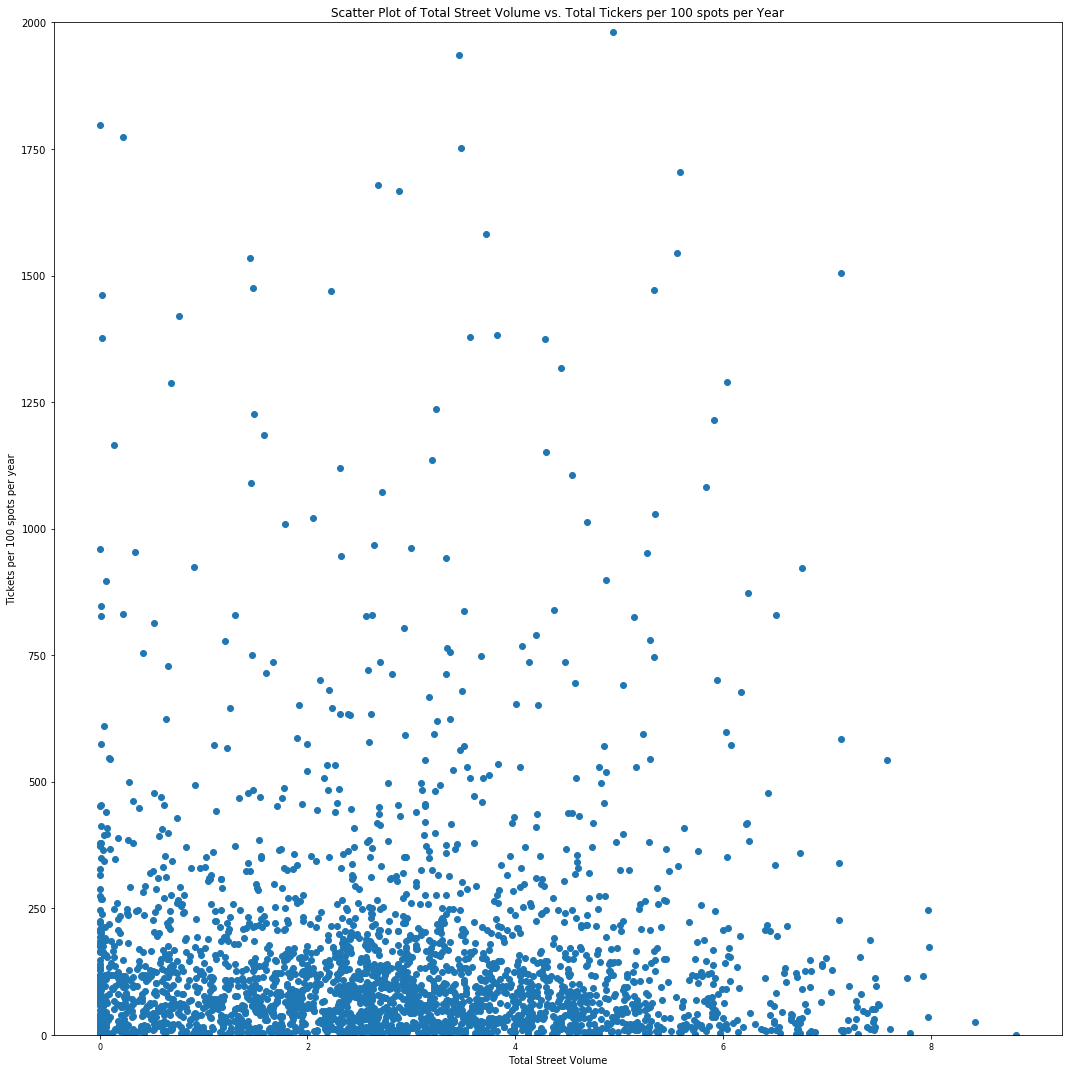

In [17]:
streets = streets[streets.tickperspot < 2000]
plt.figure(figsize = (15, 15))
plt.scatter(x = np.log(streets['total_ea']), y = streets['tickperspot'])

plt.title('Scatter Plot of Total Street Volume vs. Total Tickers per 100 spots per Year')
plt.ylabel('Tickets per 100 spots per year')
plt.xlabel('Total Street Volume')
plt.ylim(0,2000)
plt.savefig(image_folder + 'model/volvsparkspots.png')

Text(0, 0.5, 'Frequency')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


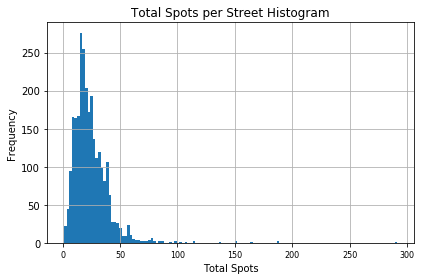

In [18]:
output = open(proc_folder +  'streetdf.pkl', 'wb')
pickle.dump(streets, output)

#Histogram of spots per street
streets['park_supply'].hist(bins = 'auto')
plt.title('Total Spots per Street Histogram')
plt.xlabel('Total Spots')
plt.ylabel('Frequency')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


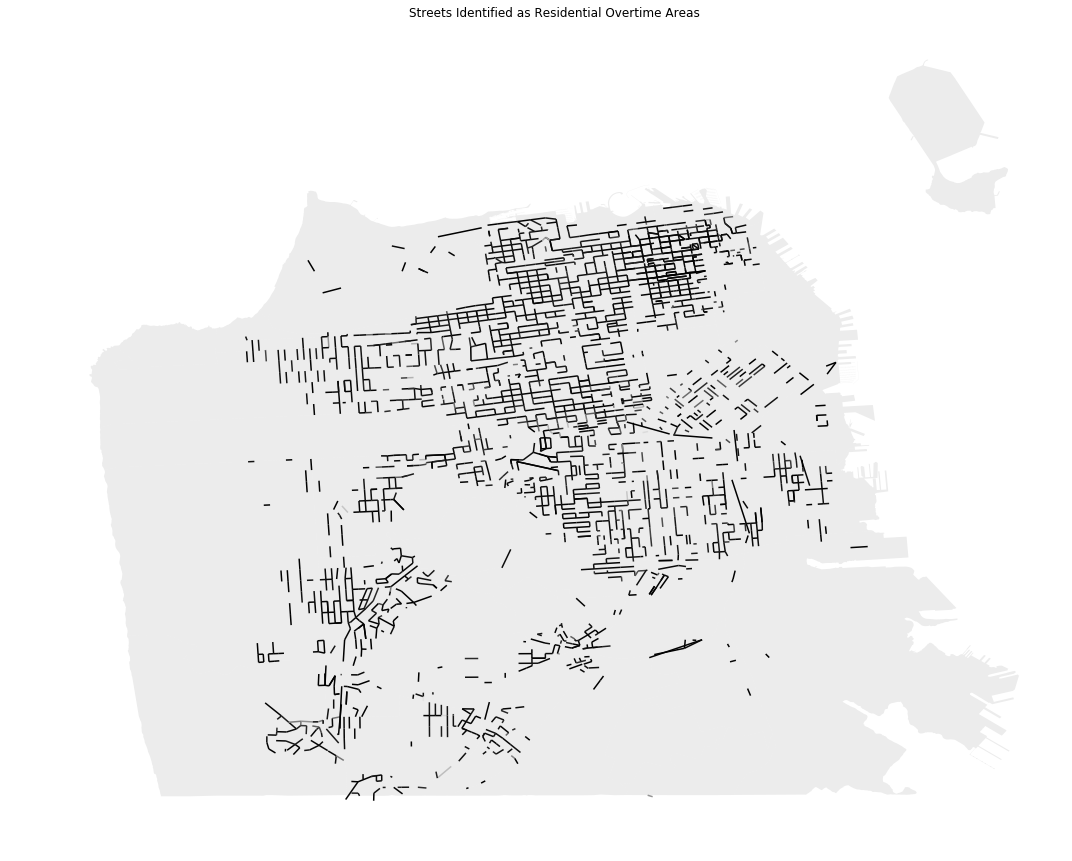

In [19]:
#Let's map all of the streets we've identified 
import geopandas as gpd
streetvolume = gpd.read_file(proc_folder + './final_streets/SF_Street_Data.shp')
nhoods = gpd.read_file(raw_folder + 'AnalysisNeighborhoods.geojson')
base = nhoods.plot(alpha = .15, color = 'gray', figsize = (15, 15))
    
streetvolume = streetvolume.to_crs(epsg = 4326)
times = ['am', 'pm', 'ev', 'ea']
for time in times:
    streetvolume['totalinv_' + time]  = streetvolume['total_'+time].apply(lambda x: np.log(1/(x+.5)))
    
df = streetvolume.merge(streets, left_on = 'lineid', right_on = 'lineid')
    
df.plot(ax = base, figsize = (20,20), cmap = 'gray', column = 'tickperspot')
plt.title('Streets Identified as Residential Overtime Areas')
plt.axis('off')
plt.savefig(image_folder + 'model/idstreets.png')

In [20]:
streets['total_tickets'].sum()

173490

In [21]:
#Lets split into two populations based on their street volume, we will then create a weighted total average of tickets per 100 spots
df_lowvol = streets[streets.total_ea <=  np.percentile(streets['total_ea'], 50)]
df_highvol = streets[streets.total_ea > np.percentile(streets['total_ea'], 50)]

In [22]:
df_lowvol['weight'] = df_lowvol['park_supply'] / df_lowvol['park_supply'].sum()
(df_lowvol['weight'] * df_lowvol['tickperspot']).sum()

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


130.05895699039633

In [23]:
df_highvol['weight'] = df_highvol['park_supply'] / df_highvol['park_supply'].sum()
(df_highvol['weight'] * df_highvol['tickperspot']).sum()

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


117.12877116295377

They are extremely similar, and highger street volume appears to correlate with mroe tickets. 

In [24]:
#Let's split into smaller groups
df_1 = streets[streets.total_ea <=  np.percentile(streets['total_ea'], 25)]
df_2 = streets[(streets.total_ea <= np.percentile(streets['total_ea'], 50)) & (streets.total_ea >  np.percentile(streets['total_ea'], 25))]
df_3 = streets[(streets.total_ea <= np.percentile(streets['total_ea'], 75)) & (streets.total_ea >  np.percentile(streets['total_ea'], 50))]
df_4 = streets[streets.total_ea > np.percentile(streets['total_ea'], 75)]

df_1.describe()

,lineid,distance,total_ea,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,total_tickets,park_supply,parkpermile,tickperspot
count,669.000000,669.000000,669.000000,669.000000,669.000000,669.0,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000
mean,43096.010463,0.084682,1.909844,0.866021,0.043824,0.0,15.109618,0.071749,78.940209,26.859176,320.359157,148.981711
std,5695.728330,0.034424,0.907225,0.873143,0.080916,0.0,1.688420,0.258265,97.320690,13.334370,97.366493,204.465956
min,30190.000000,0.010000,1.000010,0.000000,0.000000,0.0,11.111110,0.000000,2.000000,2.506861,55.555556,2.048296
25%,39026.000000,0.060000,1.070860,0.062500,0.001850,0.0,13.888890,0.000000,17.000000,17.548025,278.190600,37.435016
50%,43509.000000,0.090000,1.663660,0.593750,0.011280,0.0,13.888890,0.000000,43.000000,25.000000,309.090909,91.921078
75%,47465.000000,0.110000,2.545470,1.487180,0.047990,0.0,16.666670,0.000000,99.000000,34.000000,350.000000,176.747086
max,57745.000000,0.270000,4.031000,2.991070,0.682950,0.0,19.444440,1.000000,824.000000,98.000000,1300.000000,1797.380005


In [25]:
df_4.describe()

,lineid,distance,total_ea,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,total_tickets,park_supply,parkpermile,tickperspot
count,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000
mean,43780.686099,0.079095,322.205655,298.855080,15.404955,6.945620,17.075016,0.246637,54.481315,23.194766,311.664559,153.587771
std,5522.867969,0.062797,525.171391,499.535168,28.532442,10.313401,3.847890,0.431376,72.228399,20.927355,286.861932,238.776953
min,28409.000000,0.005500,54.244300,22.406750,0.073460,0.000000,8.866510,0.000000,2.000000,2.000000,42.857143,0.315904
25%,40481.000000,0.050000,83.986570,70.802540,2.695150,0.000000,13.888890,0.000000,12.000000,13.000000,250.686066,31.684583
50%,44830.000000,0.060000,133.708210,120.072780,6.230920,0.000000,16.666630,0.000000,30.000000,18.058015,298.805636,75.748751
75%,47220.000000,0.090000,327.056870,306.190910,13.798450,12.000000,19.404330,0.000000,67.000000,28.000000,338.974000,157.462778
max,57747.000000,0.690000,6780.863410,6344.826690,413.856720,90.000000,54.999940,1.000000,754.000000,291.776392,6181.818182,1981.726672


In this case, it may be wise to use the central limit theorem, because you will not have the availablility of streets at your fingertips when finding a parking spot. Let's do what we did in the first notebook, but on our new data. 

In [26]:
#since so many have the same value, we should probably filter the group on a sorted index so the sample sizes are all the same 
streets.sort_values(by = 'total_ea', inplace = True)
streets.reset_index(inplace = True)

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


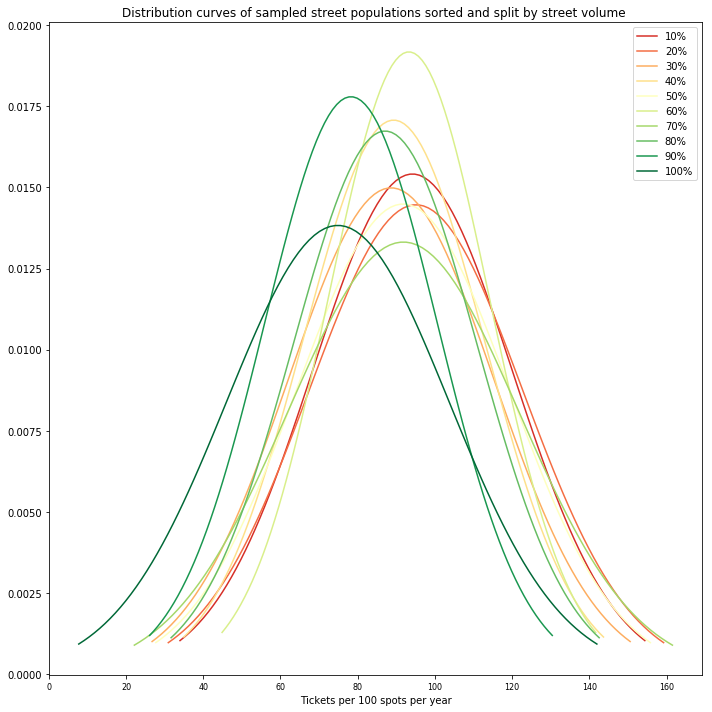

In [27]:

plt.figure(figsize = (10, 10))
means = {}
stds = {}
for i in np.arange(1,11):
    if i == 1:
        df = streets[streets.index <=  np.percentile(streets.index, i*10)]
    else:
        df = streets[(streets.index <=  np.percentile(streets.index, i*10)) & (streets.index >  np.percentile(streets.index, (i-1)*10))]
               
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/10))
plt.legend( loc = 0)
plt.title('Distribution curves of sampled street populations sorted and split by street volume ')
plt.xlabel('Tickets per 100 spots per year')
plt.savefig(image_folder + '/model/10PopVolSortedParking.png')

It looks like our higher volume streets get less tickets

Text(0.5, 0, 'Tickets per 100 spots per year')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


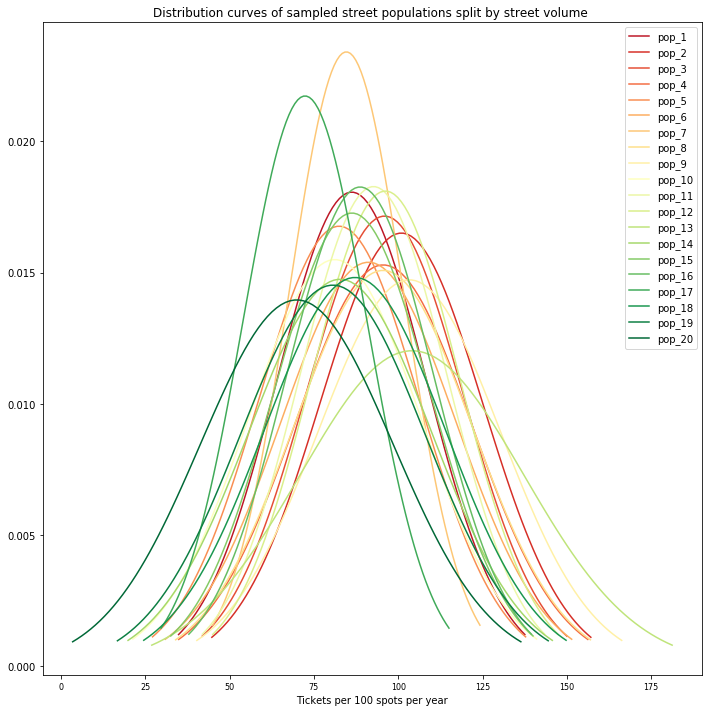

In [28]:
plt.figure(figsize = (10, 10))
means = {}
stds = {}

for i in np.arange(1,21):
    if i == 1:
        df = streets[streets.index <=  np.percentile(streets.index, i*5)]
    else:
        df = streets[(streets.index <=  np.percentile(streets.index, i*5)) & (streets.index >  np.percentile(streets.index, (i-1)*5))]
              
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = 'pop_' + str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(i/20))
plt.legend( loc = 0)
plt.title('Distribution curves of sampled street populations split by street volume ')
plt.xlabel('Tickets per 100 spots per year')

# Factor Analysis

Let's see if we can create another model using our new information. 

In [29]:
streets.head()

,index,lineid,streetname,nhood,distance,total_ea,vvol_carea,vvol_trkea,vvol_busea,speed_ea,oneway,total_tickets,park_supply,parkpermile,tickperspot
0,838,46078,COLE,Haight Ashbury,0.07,1.00001,0.0,0.00001,0.0,16.66667,0,2,23.72818,338.974000,3.884551
1,36,30973,PROSPECT,Bernal Heights,0.11,1.00001,0.0,0.00001,0.0,16.66667,0,16,45.00000,409.090909,16.386370
2,1807,45896,CENTRAL,Lone Mountain/USF,0.06,1.00001,0.0,0.00001,0.0,16.66667,0,38,22.00000,366.666667,79.604243
3,2656,50122,17TH,Outer Richmond,0.13,1.00001,0.0,0.00001,0.0,16.66667,0,73,24.00000,184.615385,140.180278
4,2721,50622,14TH,Outer Richmond,0.13,1.00002,0.0,0.00002,0.0,16.66667,0,52,49.00000,376.923077,48.908299


/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:182: UserWarning: The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The bottom and top margins cannot be made large '
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


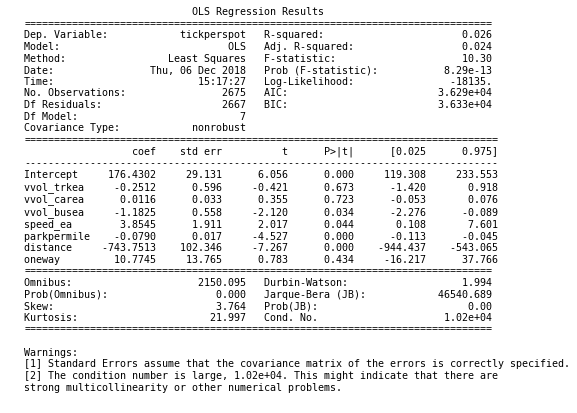

In [30]:
import statsmodels.api as sm
columns = ['vvol_trkea', 'vvol_carea', 'vvol_busea', 'speed_ea', 'parkpermile', 'distance', 'oneway']
formula = 'tickperspot ~ '+ ' + '.join(columns) 
model = sm.OLS.from_formula(formula, streets)
res = model.fit()
plt.rc('figure', figsize=(8, 5))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig(image_folder + '/model/basemodelparking.png')
plt.show()

Once again, car volume wasn't very statistically significant. 

In [31]:
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', inplace = True)

Text(0.5, 0, 'Tickets per 100 spots per year')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


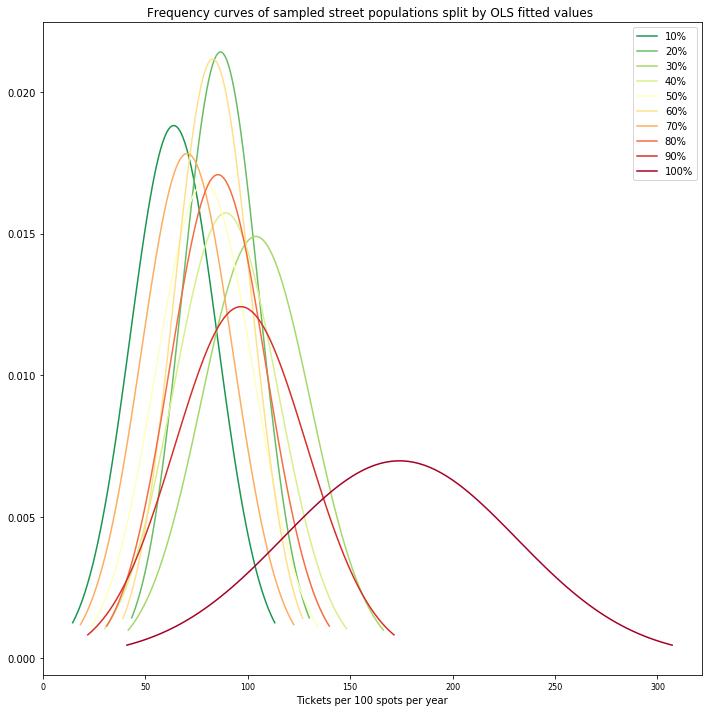

In [32]:
plt.figure(figsize = (10, 10))
means = {}
stds = {}
totalsize = streets.shape[0]
for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]
        
    sample = []
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
plt.legend( loc = 0)
plt.title('Frequency curves of sampled street populations split by OLS fitted values ')
plt.xlabel('Tickets per 100 spots per year')

Compared to the original model, this one fits much better when using it to decide streets to park at. Our r^2 is also slightly higher, although still not very high. There is a large amount of variability, and a very large sample size. 

The Higher our variables get, the fit seems to be stronger, which would confirm that using these measures may be an accurate way to estimate ticket probability. Let's check out some diagnostic plots to confirm this. 

In [33]:
model_fit = res
# fitted 
model_fitted_y = model_fit.fittedvalues

# residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag


Text(0, 0.5, 'Standardized Residuals')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


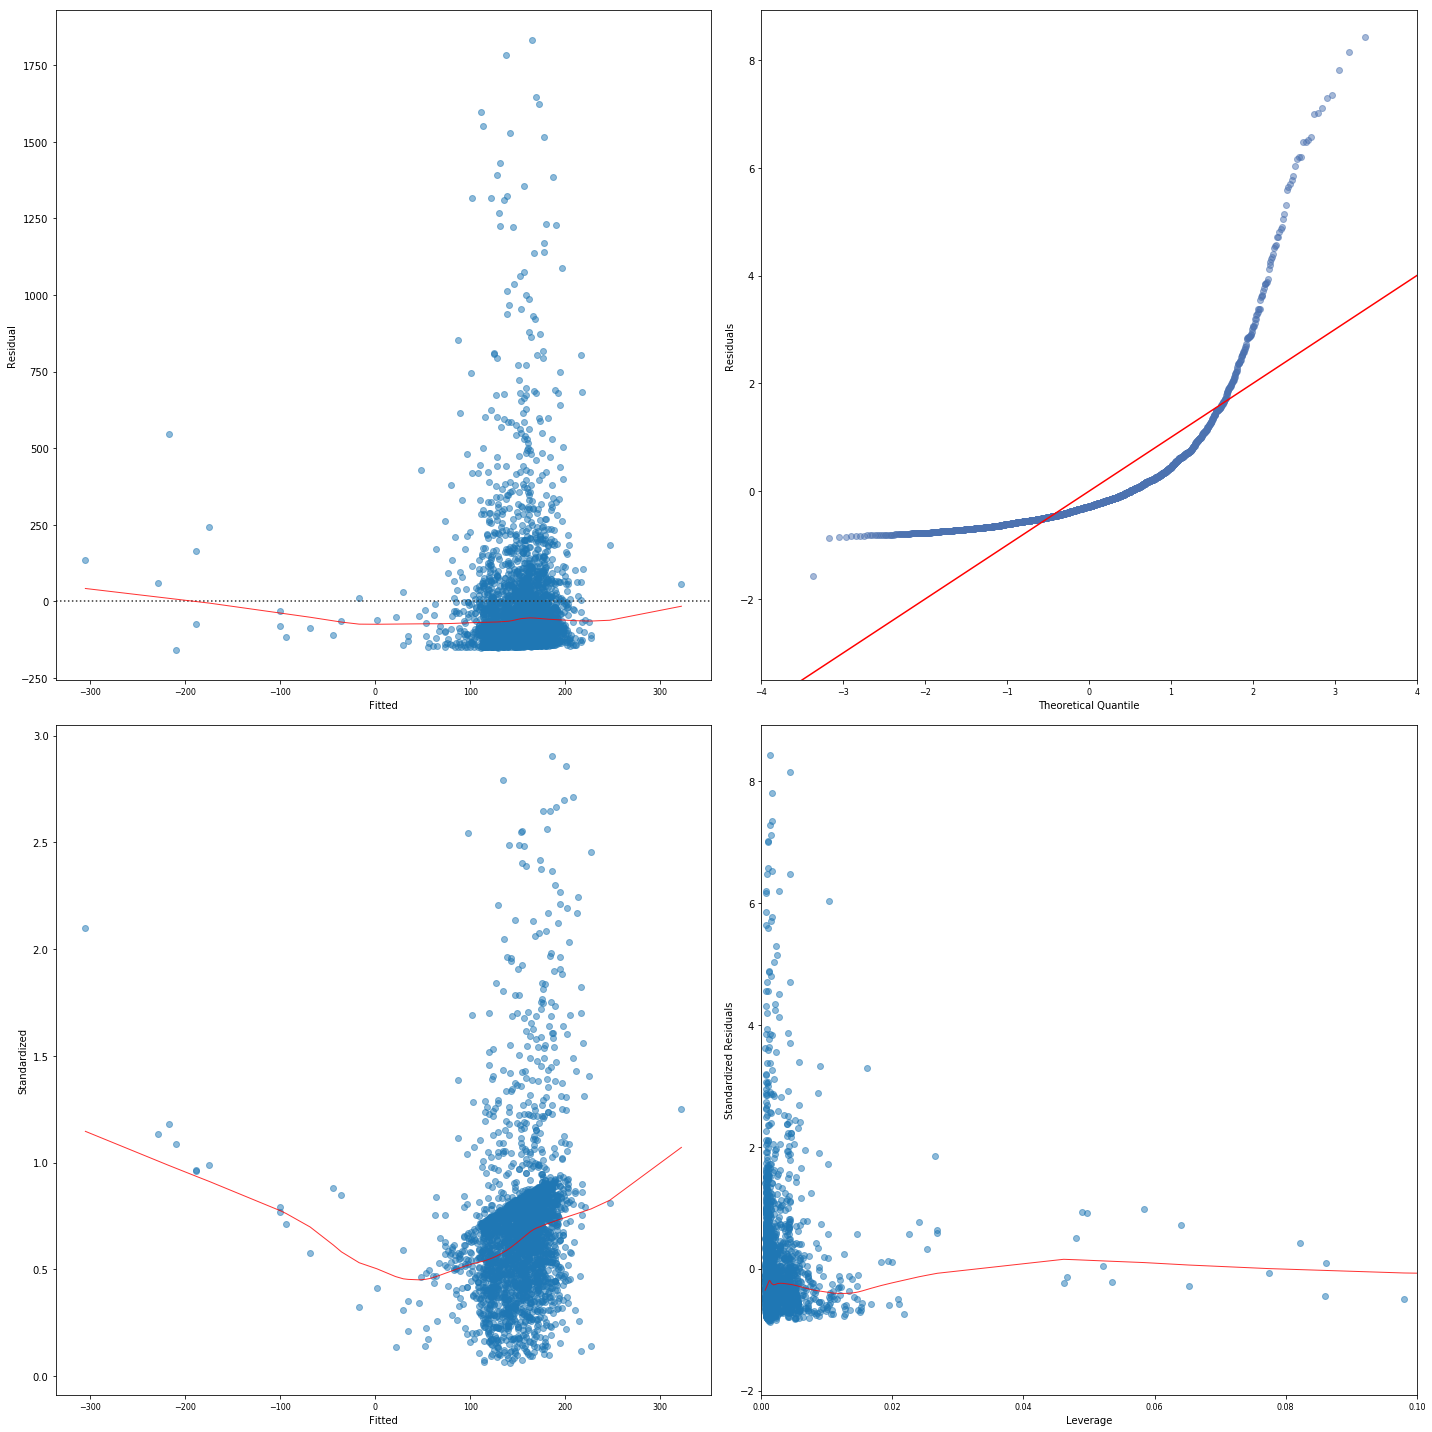

In [34]:
from statsmodels.graphics.gofplots import ProbPlot
#All four diagnostic plots in one place
fig, axarr = plt.subplots(2,2, figsize = (20,20))
QQ = ProbPlot(model_norm_residuals)

#residuals 
sns.residplot( model_fitted_y, 'tickperspot', data=streets, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[0,0])
axarr[0,0].set_xlabel('Fitted')
axarr[0,0].set_ylabel('Residual')


#Q-Q
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax = axarr[0,1])
axarr[0,1].set_xlabel('Theoretical Quantile')
axarr[0,1].set_ylabel('Residuals')
axarr[0,1].set_xlim(-4,4)



#scale - location
axarr[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,0])
axarr[1,0].set_xlabel('Fitted')
axarr[1,0].set_ylabel('Standardized')


#Leverage
axarr[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,1])
axarr[1,1].set_xlim(0,0.1)
axarr[1,1].set_xlabel('Leverage')
axarr[1,1].set_ylabel('Standardized Residuals')

The Q-Q Plot indicates there may be a non-linear relationship here. Let's try a few other fits. 

In [35]:
df = streets
for column in columns:
    df[column] = df[column] + 0.01
    
formstring = 'tickperspot ~np.log(vvol_trkea)+np.log(vvol_carea)+np.log(vvol_busea)+np.log(speed_ea) + np.log(parkpermile) + oneway'
model = sm.OLS.from_formula(formstring , streets)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            tickperspot   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     25.43
Date:                Thu, 06 Dec 2018   Prob (F-statistic):           1.62e-29
Time:                        15:17:31   Log-Likelihood:                -18097.
No. Observations:                2675   AIC:                         3.621e+04
Df Residuals:                    2668   BIC:                         3.625e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             978.8683    108.018      9.062      0.000     767.061    1190.676
np.log(vvol_trkea)      3.2218      3.889      0.828      0.408      -4.404      10.848
np.log(vvol_carea)     -1.9928      3.309     -0.602      0.547      -8.481       4.495
np.log(vvol_busea)     -4.8798      1.390     -3.511      0.000      -7.605      -2.155
np.log(speed_ea)      -29.8113     30.417     -0.980      0.327     -89.454      29.832
np.log(parkpermile)  -132.5004     10.910    -12.145      0.000    -153.894    -111.107
oneway                 -2.7473     13.218     -0.208      0.835     -28.666      23.171
==============================================================================
Omnibus:                     2034.058   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38029.848
Skew:                           3.519   Prob(JB):                         0.00
Kurtosis:                      20.078   Cond. No.                         206.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Standardized Residuals')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


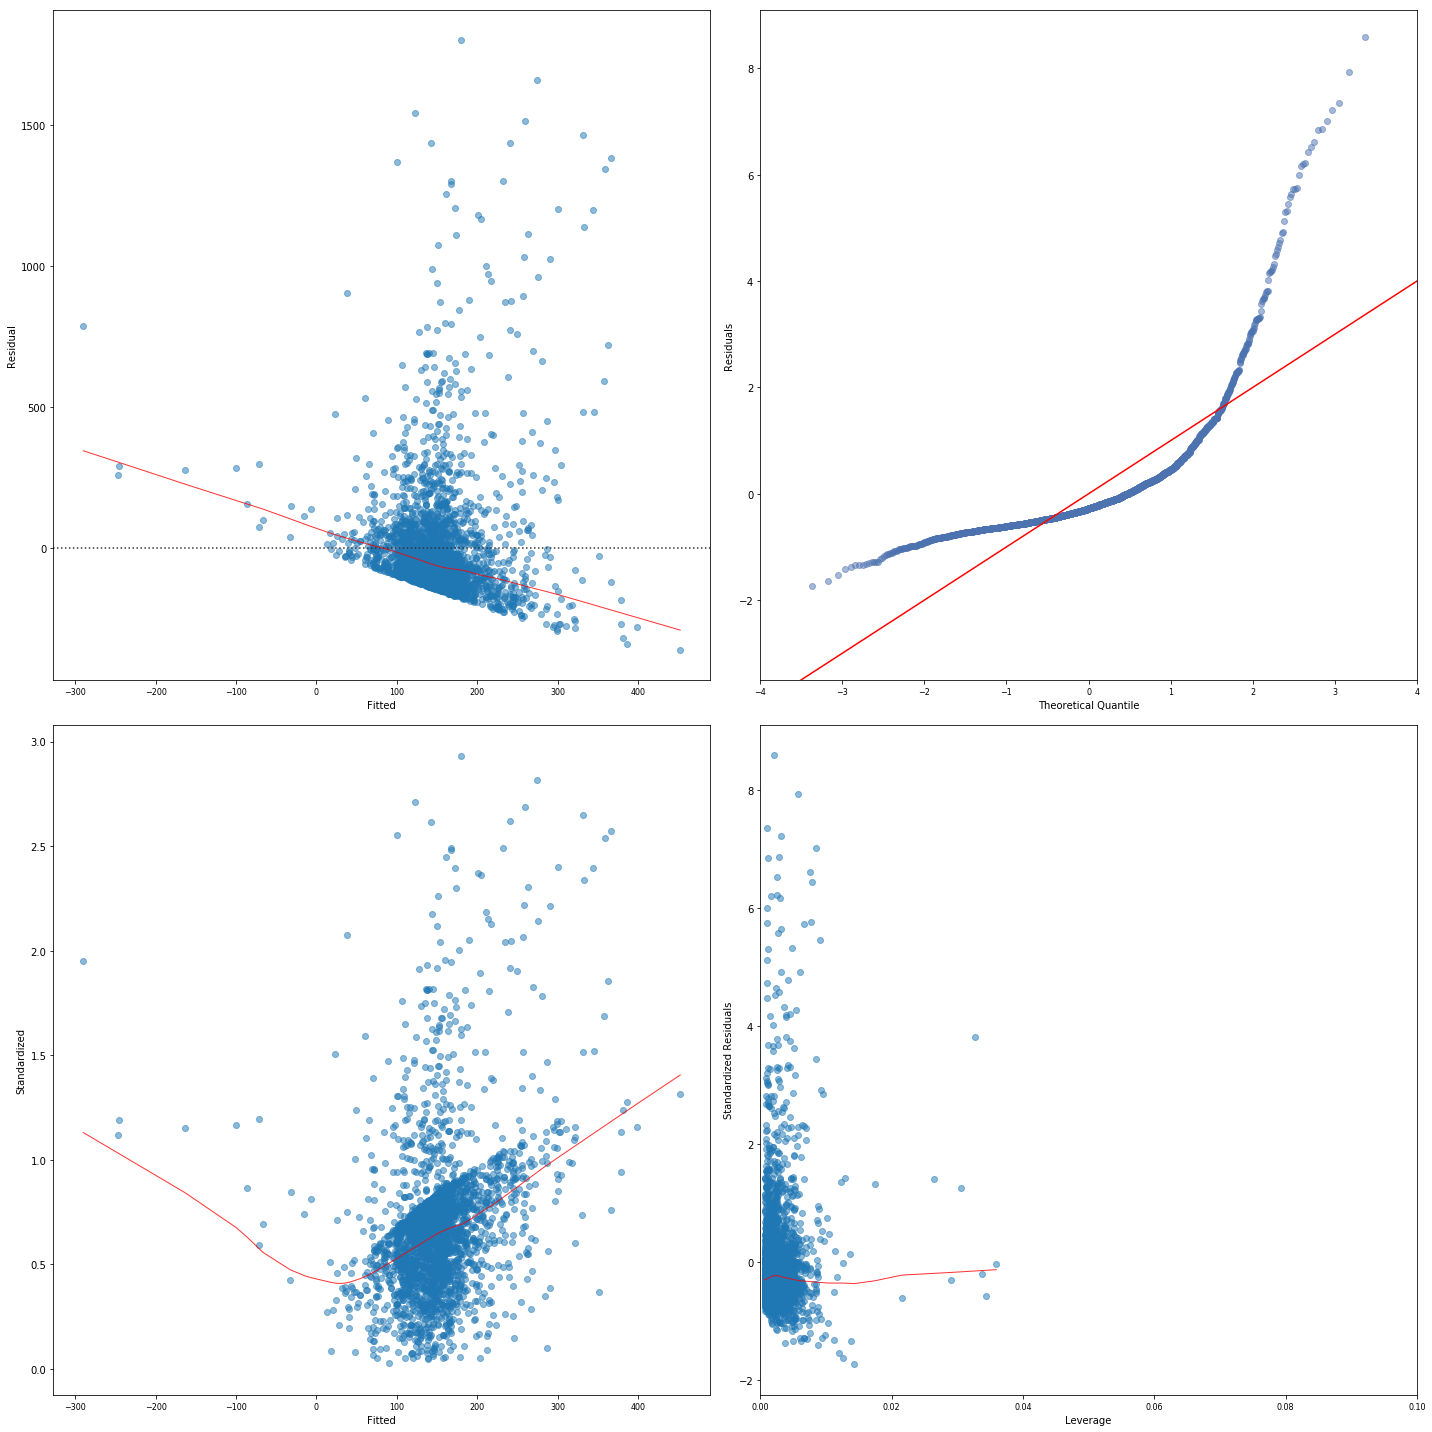

In [36]:
# Log fit seems to be a little better. 
model_fit = res
# fitted 
model_fitted_y = model_fit.fittedvalues

# residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
from statsmodels.graphics.gofplots import ProbPlot
#All four diagnostic plots in one place
fig, axarr = plt.subplots(2,2, figsize = (20,20))
QQ = ProbPlot(model_norm_residuals)

#residuals 
sns.residplot( model_fitted_y, 'tickperspot', data=streets, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[0,0])
axarr[0,0].set_xlabel('Fitted')
axarr[0,0].set_ylabel('Residual')


#Q-Q
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax = axarr[0,1])
axarr[0,1].set_xlabel('Theoretical Quantile')
axarr[0,1].set_ylabel('Residuals')
axarr[0,1].set_xlim(-4,4)



#scale - location
axarr[1,0].scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,0])
axarr[1,0].set_xlabel('Fitted')
axarr[1,0].set_ylabel('Standardized')


#Leverage
axarr[1,1].scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axarr[1,1])
axarr[1,1].set_xlim(0,0.1)
axarr[1,1].set_xlabel('Leverage')
axarr[1,1].set_ylabel('Standardized Residuals')

Text(0, 0.5, 'Frequency')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


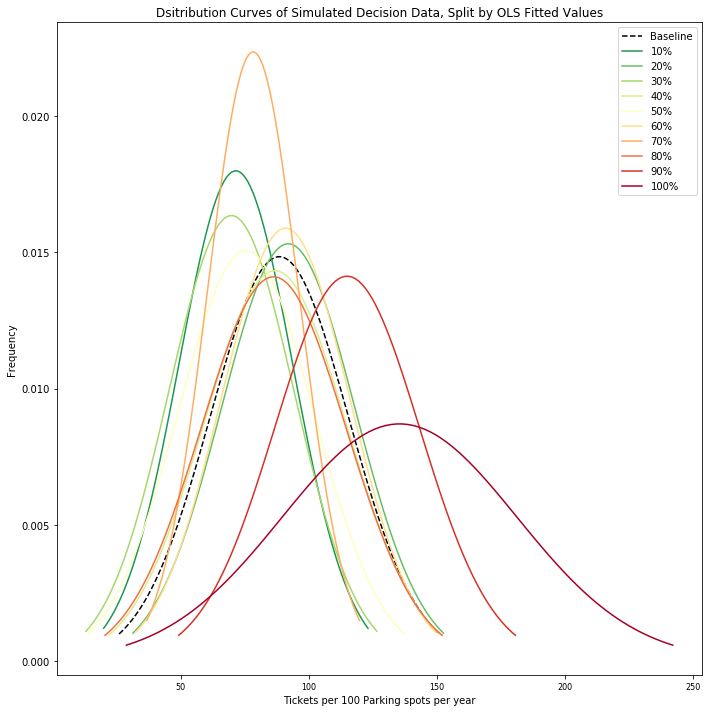

In [37]:
#Re-do our central limit exercise once again. 
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted', inplace = True)
plt.figure(figsize = (10, 10))
means = {}
stds = {}
df = streets
sample = []
boxdata = []
#create baseline curve
for j in np.arange(1,1000):
    sample.append(df['tickperspot'].sample(n = 20).median())
 

sample = np.array(sample)

means['base'] = sample.mean()
stds['base'] = sample.std()
normals = norm(loc = means['base'], scale = stds['base'])

x = np.linspace(normals.ppf(0.01), 
                    normals.ppf(0.99), 
                    100)
labelstr = str(i * 10) + '%'
plt.plot(x, normals.pdf(x), label = 'Baseline', color = 'black', linestyle = '--')

        
for i in np.arange(1,11):
    if i == 1:
        df = streets[0:int(totalsize * .1)]
    else:
        df = streets[((i-1)/10 * totalsize).astype(int): (((i)/10) * totalsize).astype(int)]
        
    sample = []
    boxdata.append(df['tickperspot'])
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i] = sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), 
                        normals.ppf(0.99), 
                        100)
    labelstr = str(i * 10) + '%'
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
plt.legend( loc = 0)
plt.title('Dsitribution Curves of Simulated Decision Data, Split by OLS Fitted Values')
plt.xlabel('Tickets per 100 Parking spots per year')
plt.ylabel('Frequency')

''

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


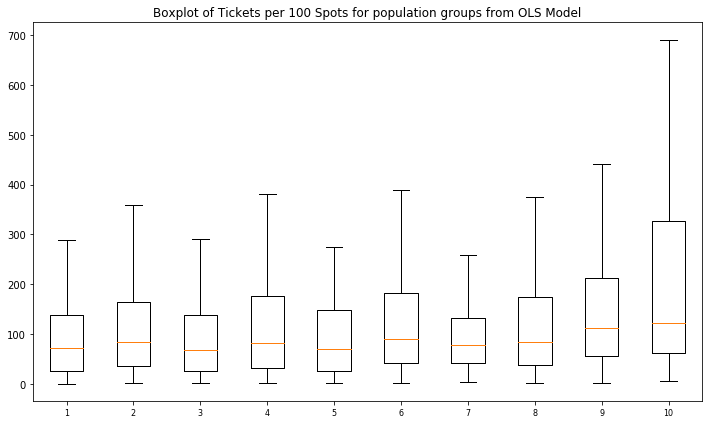

In [38]:
plt.figure(figsize = (10,6))
plt.boxplot(boxdata, showfliers = False)
plt.title('Boxplot of Tickets per 100 Spots for population groups from OLS Model')
;


Let's try to include some interactions, we'll look through all combinations of unbias predictors and add them to a model. 

In [39]:
columnlist = ['vvol_carea', 'vvol_trkea', 'vvol_busea', 'speed_ea', 'parkpermile', 'distance', 'oneway']
formulastring = 'tickperspot ~ '

formulastring += '+'.join(columns) 

for combo in itertools.combinations(columnlist, 2):
    formulastring += '+' + combo[0] + '*' + combo[1]


/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:182: UserWarning: The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The bottom and top margins cannot be made large '
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


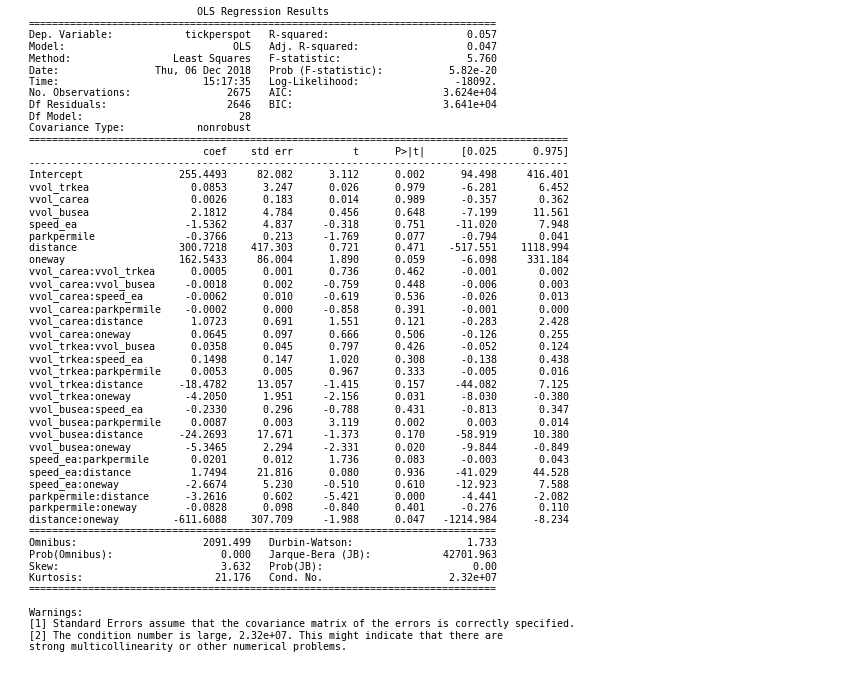

In [40]:
model = sm.OLS.from_formula(formulastring , streets)
res = model.fit()
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.show()

The main interaction that has both a significant weight and p-value is parkpermile* distance, which gives our density a third dimension. We'll include that in our final model, along with the logarithmic predictors.  

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:182: UserWarning: The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('The bottom and top margins cannot be made large '
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


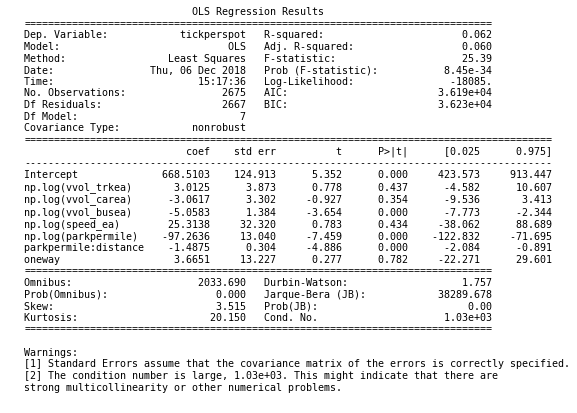

In [41]:
formstring = 'tickperspot ~np.log(vvol_trkea)+np.log(vvol_carea)+np.log(vvol_busea)+np.log(speed_ea) + np.log(parkpermile)'\
        ' + parkpermile:distance + oneway'
model = sm.OLS.from_formula(formstring , streets)
res = model.fit()
plt.rc('figure', figsize=(8, 5))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig(image_folder + '/model/finalModelFit.png')
plt.show()


/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


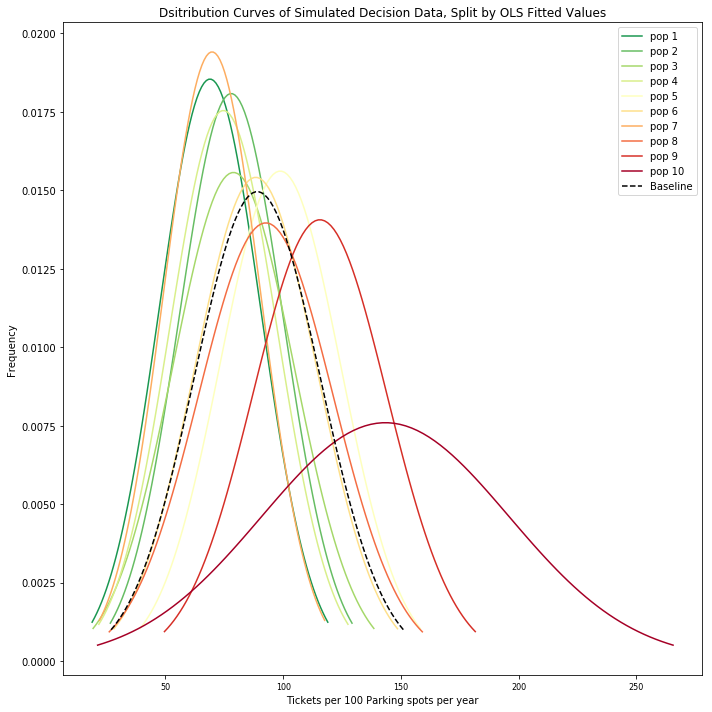

In [42]:
#Re-do our central limit exercise once again. We'll save some confidence intervals for later. 
streets['fitted'] =  res.fittedvalues
streets.sort_values(by = 'fitted',   inplace = True)
plt.figure(figsize = (10, 10))
means = {}
stds = {}
lci = {}
uci = {}
df = streets
sample = []
boxdata = []

        
for i in np.arange(1,11):
    if i == 1:
        df = streets[streets.fitted <=  np.percentile(streets.fitted, i*10)]
    else:
        df = streets[(streets.fitted <=  np.percentile(streets.fitted, i*10)) & (streets.fitted >  np.percentile(streets.fitted, (i-1)*10))]
               
    sample = []
    boxdata.append(df['tickperspot'])
    for j in np.arange(1,1000):
        sample.append(df['tickperspot'].sample(n = 20).median())
        
    sample = np.array(sample)
        
    means[i]= sample.mean()
    stds[i] = sample.std()
    normals = norm(loc = means[i], scale = stds[i])
    
    x = np.linspace(normals.ppf(0.01), normals.ppf(0.99), 100)
    labelstr = 'pop '+ str(i)
    plt.plot(x, normals.pdf(x), label = labelstr, color =  plt.cm.RdYlGn(1-(i/10)))
    
df = streets 

sample = []
#create baseline curve
for j in np.arange(1,1000):
    sample.append(df['tickperspot'].sample(n = 20).median())
sample = np.array(sample)

means['base'] = sample.mean()
stds['base'] = sample.std()
normals = norm(loc = means['base'], scale = stds['base'])

x = np.linspace(normals.ppf(0.01), normals.ppf(0.99), 100)
labelstr = 'pop '+ str(i)

plt.plot(x, normals.pdf(x), label = 'Baseline', color = 'black', linestyle = '--')
plt.legend( loc = 0)
plt.title('Dsitribution Curves of Simulated Decision Data, Split by OLS Fitted Values')
plt.xlabel('Tickets per 100 Parking spots per year')
plt.ylabel('Frequency')
plt.savefig(image_folder + '/model/10popFinalModel.png')

In [43]:
means[1] / means['base']

0.7742687035767046

In [44]:
means[1] / means[10]

0.4805584322933781

In [45]:
df_worst = streets[streets.fitted >  np.percentile(streets.fitted, (90))]
df_best = streets[streets.fitted <  np.percentile(streets.fitted, (10))]

In [46]:
streets.describe().T

,count,mean,std,min,25%,50%,75%,max
index,2675.0,1099.513645,802.368452,0.000000,437.500000,898.000000,1733.000000,2906.000000
lineid,2675.0,43476.693458,5561.425644,28409.000000,39809.000000,44239.000000,47228.500000,57758.000000
distance,2675.0,0.087854,0.043477,0.014820,0.065050,0.080000,0.100000,0.700000
total_ea,2675.0,90.341833,294.891377,1.000010,4.032790,14.608070,54.236330,6780.863410
vvol_carea,2675.0,81.668566,279.583691,0.010000,1.936560,9.794560,43.138390,6344.836690
vvol_trkea,2675.0,4.199039,15.682856,0.010000,0.055265,0.355340,1.776610,413.866720
vvol_busea,2675.0,3.504228,7.546988,0.010000,0.010000,0.010000,0.010000,90.010000
speed_ea,2675.0,15.706097,2.546184,8.876510,13.898890,16.676660,16.676670,55.009940
oneway,2675.0,0.129252,0.324146,0.010000,0.010000,0.010000,0.010000,1.010000
total_tickets,2675.0,64.856075,82.079872,2.000000,15.000000,37.000000,81.000000,824.000000


In [47]:
df_worst.describe().T

,count,mean,std,min,25%,50%,75%,max
index,268.0,1466.832090,896.604309,1.000000,649.500000,1503.500000,2219.500000,2906.000000
lineid,268.0,43375.585821,6022.024156,28409.000000,39461.500000,44439.500000,47467.000000,57756.000000
distance,268.0,0.083000,0.041434,0.020000,0.060000,0.070000,0.100000,0.410000
total_ea,268.0,102.189517,261.177107,1.000010,4.640197,17.225370,74.655732,2777.295610
vvol_carea,268.0,93.525683,248.660517,0.010000,3.292107,12.475540,70.358700,2669.155050
vvol_trkea,268.0,4.047789,10.837941,0.010000,0.068320,0.474780,2.308580,71.500450
vvol_busea,268.0,3.646045,7.511100,0.010000,0.010000,0.010000,0.010000,42.410000
speed_ea,268.0,16.281489,2.229613,11.121110,13.898890,16.676670,16.676670,25.009950
oneway,268.0,0.159254,0.357005,0.010000,0.010000,0.010000,0.010000,1.010000
total_tickets,268.0,58.085821,84.738086,2.000000,11.000000,29.000000,65.250000,607.000000


In [48]:
df_best.describe().T

,count,mean,std,min,25%,50%,75%,max
index,268.0,967.048507,758.295502,6.000000,407.750000,598.000000,1501.000000,2894.000000
lineid,268.0,43167.873134,5766.800434,29593.000000,38276.250000,44129.500000,46298.500000,56983.000000
distance,268.0,0.120455,0.083380,0.014820,0.080000,0.100000,0.140000,0.700000
total_ea,268.0,143.075933,599.407050,1.000210,5.601985,19.099040,54.601838,6780.863410
vvol_carea,268.0,129.160382,565.536940,0.010000,2.020715,9.561260,42.109542,6344.836690
vvol_trkea,268.0,6.562118,33.523119,0.010000,0.043897,0.265870,1.427370,413.866720
vvol_busea,268.0,6.383433,9.431899,0.010000,0.010000,0.010000,12.010000,48.010000
speed_ea,268.0,16.142606,4.599907,8.876510,13.898890,16.676670,16.676670,55.009940
oneway,268.0,0.133134,0.329206,0.010000,0.010000,0.010000,0.010000,1.010000
total_tickets,268.0,92.313433,98.787740,2.000000,22.000000,63.500000,122.250000,626.000000


In [49]:
#Lets compare worst and best against total set and make it look pretty
comparison = pd.concat([streets.describe().T['mean'],df_worst.describe().T['mean'], df_best.describe().T['mean'] ], axis = 1)
comparison.drop(index = 'total_tickets', inplace = True)
comparison.columns = ['Total Set', 'Worst', 'Best']
comparison[2:-2]
comparison = comparison[2:-1]
comparison['Total Set'] = round(comparison['Total Set'], 2)
comparison['Worst'] = round((comparison['Worst'] - comparison['Total Set']) / comparison['Total Set'], 2)
comparison['Best'] = round((comparison['Best'] - comparison['Total Set']) / comparison['Total Set'], 2)
comparison = comparison.style.set_properties(**{'text-align': 'center', 'border-color': 'black'}).bar(subset=['Best', 'Worst'], align='zero', color=['#d65f5f', '#5fba7d'])
comparison

,Total Set,Worst,Best
distance,0.09,-0.08,0.34
total_ea,90.34,0.13,0.58
vvol_carea,81.67,0.15,0.58
vvol_trkea,4.2,-0.04,0.56
vvol_busea,3.5,0.04,0.82
speed_ea,15.71,0.04,0.03
oneway,0.13,0.23,0.02
park_supply,24.13,-0.58,1.06
parkpermile,319.04,-0.54,0.79
tickperspot,150.86,0.99,-0.35


In [50]:
html_str = comparison.render()

Html_file= open("comptable.html","w")
Html_file.write(html_str)
Html_file.close()

# Question
How long can I actually park at a residential overtime area, and hope I don't get a ticket?

This one is much more theoretical and more just for a little challening fun, as we would need a lot more data to fully answer it with concrete numbers. We would need more information on travel paths of the officers, and potentially some data on the cars that were parked. However, we can try and take a stab at it using some high level numbers. 

First, lets clarify the assumptions and process for estimating this probaility. There are two parts we must solve in this question. The first part is the probability that they come down the street you are parked in. This probability will increase with time. The second includes the probability they come back, and in what time frame. 

Part 1. We'll assume the same success rate of each street, as in every X parking spots he passes on any street, they'll get one. But how do we arrive at this? We'll need some very high level estimates. First, we'll estimate the total number of spots they pass. 


We'll assume he travels roughly 75% of the weighted average freeflow speed(while he is looking for offenders), as from visual estimates. We'll also assume their full day is about 75% utilized over 6 hours a day.We'll also take time out for writing tickets, ~ 2 minutes each. 




In [51]:
streetdata = result_query('Select lineid, distance, park_supply, speed_ea from street_volume_data')

ticket_data = result_query("Select * from ticket_data where ViolationDesc = 'RES/OT' ")

address_data = result_query('Select address, lineid from address_data')

df = ticket_data.merge(address_data, left_on = 'address', right_on = 'address')
df = df.merge(streetdata, left_on = 'lineid', right_on = 'lineid')

c.execute("Select Count(distinct lineid) from ticket_data t1 join address_data t2 on t1.address = t2.address")
totalticks = c.fetchone()[0]
c.execute("Select Count(distinct lineid) from ticket_data t1 join address_data t2 on t1.address = t2.address where violationdesc = 'RES/OT'")
resticks = c.fetchone()[0]

percent_res = resticks/totalticks

In [52]:
#find the average of non street cleaning per day 
df['TickDate']= df['TickIssueDate'].apply(lambda x: pd.to_datetime(x).date())
tix_by_officer = df.groupby(by = ['TickDate','TickBadgeIssued'], as_index = False)['TicketNumber'].size().reset_index(name='counts')

In [53]:
#Let's see how many officers per day are patrolling
officer_by_day = tix_by_officer.groupby(by = ['TickDate'], as_index = False).size().reset_index(name='counts')
avg_officers = officer_by_day['counts'].mean()
avg_officers

22.603719599427755

In [54]:
avg_tix = tix_by_officer['counts'].mean()
avg_tix

16.07518987341772

Roughly 22 officers and 18 tickets

In [55]:

average_freeflow_speed = df['speed_ea'].mean() * .75

validstreet = streetdata[streetdata.park_supply > 0 ]

average_spots_per_mile = validstreet['park_supply'] / validstreet['distance']
average_spots_per_mile = average_spots_per_mile.mean()
print(average_spots_per_mile)                            
total_spots_per_day = average_freeflow_speed * (6-avg_tix*2/60) * percent_res * average_spots_per_mile 
total_spots_per_day

326.8296325826144


8292.461206066235

Now we need to find total residential parking spots

In [56]:
#Now well take the average number of spots per street and multiply it by the total number of streets

mean_parking_spots = df['park_supply'].mean()

total_spots = mean_parking_spots * df['lineid'].nunique()
total_spots

62641.75057089312

In [57]:
total_spots_checked = total_spots_per_day * avg_officers

In [58]:
total_spots_checked

187440.46789105367

In [59]:
#Arrival rate in miuntes
average_checks = total_spots_checked / total_spots

print(average_checks)
arrival_rate = 10*60 / average_checks
print(arrival_rate)

2.9922610109518404
200.51726697770243


So you can expect that each spot, on average, will be checked roughly 3.54 times a day.  Most residential permit areas are restricted from 8AM to 8PM, so 12 hours total, but take out 2 because you can't get a ticket after parking past the 10th hour. We'll use an exponential distribution  to plot the probability of seeing an officer in X time units. 

(0, 400)

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


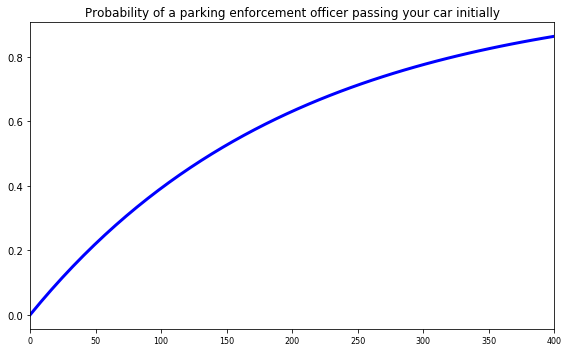

In [60]:
from scipy.stats import expon
x = np.linspace(0,400)
ax = plt.figure()
prob = stats.expon.cdf(x=x, scale= arrival_rate)
plt.plot(x, prob, color = "blue", linewidth = 3)
plt.title("Probability of a parking enforcement officer passing your car initially")
plt.xlim(0,400)

Part 2. 
On each ticket, they write down what time they first came and marked your car, and then what time they wrote the ticket. This implies they have a list of which cars they marked and where, and attempt to go check on them. Unfortunately, the initial time checked and the time returned were not included in the data. We will have to look for special circumstances under which we can find a distribution. We will look for circumstances where a ticketing officer wrote two tickets on the same street, but not within roughly 2 and 4 hours  of each other. this is under the assumption he marked the first car after he wrote the second. 

In [61]:
df['TickDate'] = df['TickIssueDate'].apply(lambda x:  dt.datetime.strftime(pd.to_datetime(x),'%Y-%m-%d'))

In [62]:
df = df[['TickBadgeIssued', 'TickIssueDate', 'TicketNumber', 'TickIssueTime', 'lineid', 'TickDate']]

In [63]:
df = df.merge(df, left_on = ['TickDate', 'lineid', 'TickBadgeIssued'], right_on = ['TickDate', 'lineid', 'TickBadgeIssued'])

In [64]:
def delta_minutes(x,y):
    timedelta = y-x
    
    return timedelta.seconds / 60
    

In [65]:
df= df[(df.TicketNumber_x != df.TicketNumber_y) & (df.TickIssueTime_y > df.TickIssueTime_x)]
df['delta'] = df.apply(lambda x: delta_minutes(pd.to_datetime(x['TickIssueDate_x']), pd.to_datetime(x['TickIssueDate_y'])), axis = 1)

In [66]:
df

,TickBadgeIssued,TickIssueDate_x,TicketNumber_x,TickIssueTime_x,lineid,TickDate,TickIssueDate_y,TicketNumber_y,TickIssueTime_y,delta
1,000022,2016-07-11 11:31:00,870006561,11:31,48940.0,2016-07-11,2016-07-11 11:36:00,870006605,11:36,5.0
2,000022,2016-07-11 11:31:00,870006561,11:31,48940.0,2016-07-11,2016-07-11 11:32:00,870006572,11:32,1.0
3,000022,2016-07-11 11:31:00,870006561,11:31,48940.0,2016-07-11,2016-07-11 11:34:00,870006583,11:34,3.0
9,000022,2016-07-11 11:32:00,870006572,11:32,48940.0,2016-07-11,2016-07-11 11:36:00,870006605,11:36,4.0
11,000022,2016-07-11 11:32:00,870006572,11:32,48940.0,2016-07-11,2016-07-11 11:34:00,870006583,11:34,2.0
13,000022,2016-07-11 11:34:00,870006583,11:34,48940.0,2016-07-11,2016-07-11 11:36:00,870006605,11:36,2.0
25,000194,2016-08-01 12:53:00,871494245,12:53,48940.0,2016-08-01,2016-08-01 13:05:00,871494260,13:05,12.0
26,000194,2016-08-01 11:53:00,871494120,11:53,48940.0,2016-08-01,2016-08-01 12:53:00,871494245,12:53,60.0
29,000194,2016-08-01 11:53:00,871494120,11:53,48940.0,2016-08-01,2016-08-01 12:34:00,871494212,12:34,41.0
30,000194,2016-08-01 11:53:00,871494120,11:53,48940.0,2016-08-01,2016-08-01 12:28:00,871494201,12:28,35.0


In [67]:
#Only include that between 1 and 4 hours
df = df[(df.delta > 60) & (df.delta < 240)]

Text(0, 0.5, 'Frequency')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


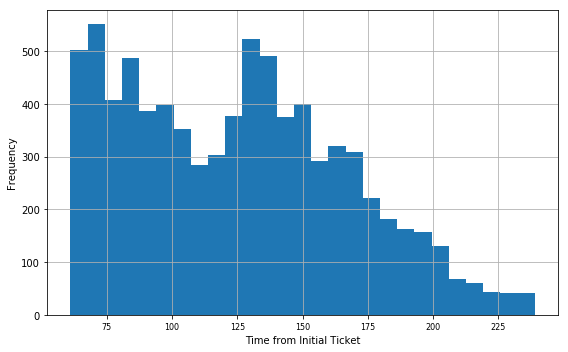

In [68]:
#This will be the ditribution of the 'return rate'
df['delta'].hist(bins = 'auto')
plt.xlabel('Time from Initial Ticket')
plt.ylabel('Frequency')

This is interesting and something I would expect. It also implies for many of these streets that they will come intermediatey to check anyway, and it is most liekly a standard route. We only really care about the distribution after 120 minutes, when he can give you a ticket. We'll also filter on less than 3 hours, beuase the distribution tails off there, and I would expect if might be because they passed through multiple times. 

Text(0, 0.5, 'Frequency')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


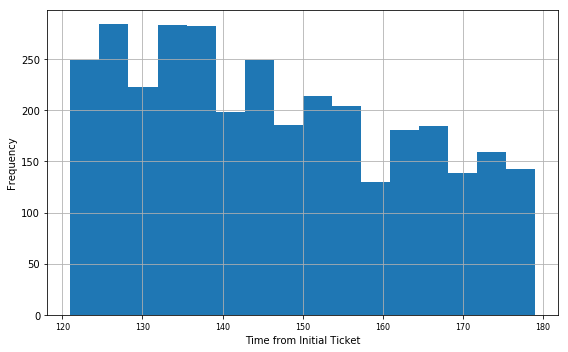

In [69]:
df = df[(df.delta > 120) & (df.delta < 180)]
df['delta'].hist(bins = 'auto')
plt.xlabel('Time from Initial Ticket')
plt.ylabel('Frequency')

W'ell turn this into a cumulative distribution. 

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


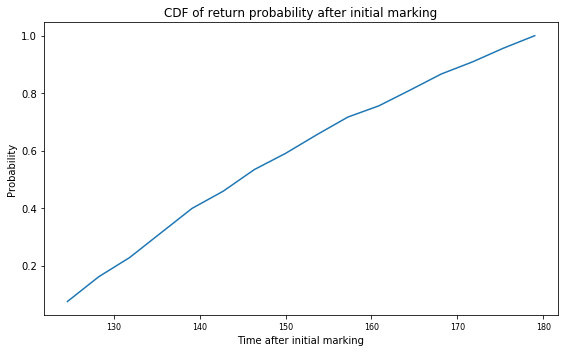

In [70]:
counts, bin_edges = np.histogram(df['delta'], bins = 'auto', normed = True)

cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.xlabel('Time after initial marking')
plt.ylabel('Probability')
plt.title('CDF of return probability after initial marking')
plt.show()

Now we combine this with our original probability of rate. Because these probabilities are sepaarate dimensions,we will have to use simulated data to create one probability distribution. 

In [71]:
#Add initial arrival time
x = np.random.random(size = 1000)

def f(x, arrival_rate):
    return -math.log(1.0 - x) / (1/arrival_rate)

firstpass = [f(x, arrival_rate) for x in x]
#firstpass = firstpass.rvs(size = 1000)
#Create discrete random variable from 2nd arrival rate distribution
values = df['delta']
probs = 1/ df['delta'].shape[0]
combination = pd.DataFrame({'val': values, 'probs' : probs})
df = combination.groupby(by = 'val', as_index = False)['probs'].sum()
custom = stats.rv_discrete(values = (df['val'], df['probs']))
secondpass = custom.rvs(size = 1000)

totalprob =  firstpass + secondpass


/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.
/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


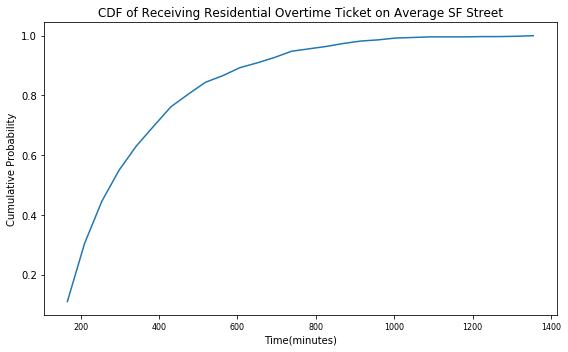

In [72]:
counts, bin_edges = np.histogram(totalprob, bins = 'auto', normed = True)
cdf = np.cumsum(counts)
plt.plot(bin_edges[1:], cdf/cdf[-1])
plt.title('CDF of Receiving Residential Overtime Ticket on Average SF Street')
plt.ylabel("Cumulative Probability")
plt.xlabel("Time(minutes)")
plt.show()

However, this study was based around the variability of arrival rates by streets, so lets use the arrival rates from our least and most patrolled streets, categorized from our regression model. 

We know that we can identify streets he is less likely to travel down, so lets compare some different probability plots. That of the highest category, that of the overall average, and that of the worst category. We'll also try to include some confidence intervals. 

/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleD

Text(0.5, 1.0, 'Probability of receiveing a ticket, split by OLS fitted volume populations')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


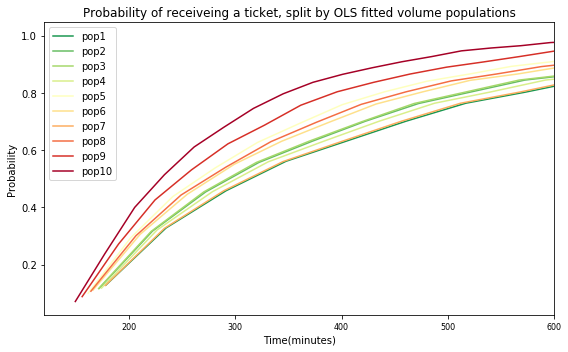

In [73]:
def plot_mean(mean, title, color):
    firstpass_mean = [f(x, mean) for x in x]
    totalprob_mean =  firstpass_mean + secondpass
    counts_mean, bin_edges_mean = np.histogram(totalprob_mean, bins = 'auto', normed = True)
    cdf_mean = np.cumsum(counts_mean)    
    plt.plot(bin_edges_mean[1:], cdf_mean/cdf_mean[-1], color =color, label = title)
    
for i in range(1,11):
    mean= arrival_rate * means['base'] / means[i]
    title = 'pop' + str(i)
    color = plt.cm.RdYlGn(1-i/10)
    plot_mean(mean, title, color)

plt.legend()
plt.xlabel('Time(minutes)')
plt.ylabel('Probability')
plt.xlim(120,600)
plt.title('Probability of receiveing a ticket, split by OLS fitted volume populations')


/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/colin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been 

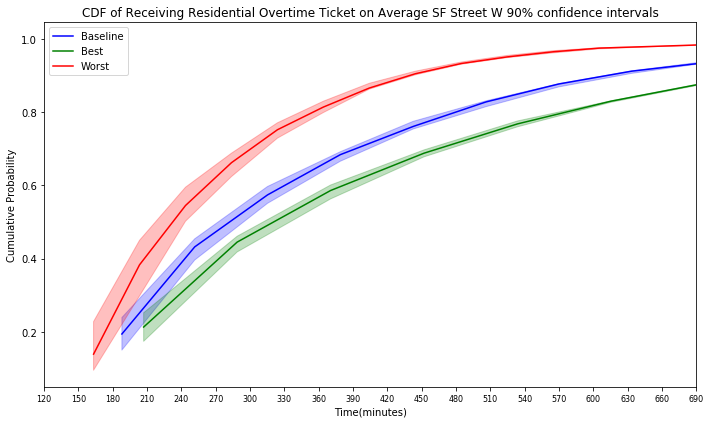

In [74]:
plt.figure(figsize = (10,6))
arrival = arrival_rate
arrival_lci = arrival_rate *   means['base'] / (means['base'] + 1.64*stds['base'])
arrival_uci = arrival_rate *  means['base'] / (means['base'] - 1.64*stds['base'])
   
arrival_best = arrival_rate * means['base'] / means[1]
arrival_best_lci = arrival_rate * means['base'] / (means[1] - 1.64*stds[1])
arrival_best_uci = arrival_rate * means['base'] / (means[1] + 1.64*stds[1])

arrival_worst = arrival_rate * means['base'] / means[10]
arrival_worst_lci = arrival_rate * means['base'] / (means[10] - 1.64*stds[10])
arrival_worst_uci = arrival_rate * means['base'] / (means[10] + 1.64*stds[10])

x = np.random.random(size = 1000)

def f(x, arrival):
    return -math.log(1.0 - x) / (1/arrival)


def plot_mean_ci(mean, lci, uci, title, color):
    firstpass_lci = [f(x, lci) for x in x]
    firstpass_mean = [f(x, mean) for x in x]
    firstpass_uci = [f(x, uci) for x in x]
    
    totalprob_lci =  firstpass_lci + secondpass
    totalprob_mean =  firstpass_mean + secondpass
    totalprob_uci =  firstpass_uci + secondpass

    
    counts_mean, bin_edges_mean = np.histogram(totalprob_mean, bins = 30, normed = True)
    cdf_mean = np.cumsum(counts_mean)
    
    counts_low, bin_edges_low = np.histogram(totalprob_lci, bins = 30, normed = True)
    cdf_low = np.cumsum(counts_low)

    counts_high, bin_edges_high = np.histogram(totalprob_uci, bins = 30, normed = True)
    cdf_high = np.cumsum(counts_high)
    
    
   
    x_ = bin_edges_mean[1:]
    plt.plot(bin_edges_mean[1:], cdf_mean/cdf_mean[-1], color = color, label = title)
    #plt.fill_between(range(bin_edges_mean.min, bin_edges_mean.max), cdf_low, cdf_high, color = color, alpha = .25)
    plt.fill_between(x_,cdf_low/cdf_low[-1], cdf_high/cdf_high[-1], color = color, alpha = .25)


plot_mean_ci(arrival, arrival_lci, arrival_uci, 'Baseline', 'blue')
plot_mean_ci(arrival_best, arrival_best_lci, arrival_best_uci, 'Best', 'green')
plot_mean_ci(arrival_worst, arrival_worst_lci, arrival_worst_uci, 'Worst', 'red')
plt.title('CDF of Receiving Residential Overtime Ticket on Average SF Street W 90% confidence intervals')
plt.ylabel("Cumulative Probability")
plt.xlabel("Time(minutes)")
plt.legend()
plt.xlim(120,480)
plt.xticks(np.arange(120,720,30))
plt.show()


# Theory
Although more street cleaning tickets are given out at 8 AM, 12 PM is more effective per linear foot because it is in the middle of the day and people(myself) would forget. Also, less consistency (once a week, every other week, etc) increases the effectiveness of getting tickets (per street clean). 2 AM is least effective because no one dares try to wake up beforehand. 
We'll use the street cleaning ID on this one to look at what links get the most street cleaning tickets. 

In [75]:
sweep = result_query('Select t1.lineid, fromhour, tohour, weekday, totalpermonth,  distance, nhood, park_supply from street_sweep_data t1 '
                  'join street_volume_data t2 on t1.lineid = t2.lineid')
sweep = sweep[sweep.weekday != 'holiday']
ticks = result_query("Select TicketNumber, TickIssueDate, TickIssueTime, lineid from ticket_data t1 join address_data t2 "
                     " on t1.address = t2.address where ViolationDesc = 'STR CLEAN'")
weekdaydict = {0: 'Mon', 1:'Tues', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

ticks['weekday'] = ticks['TickIssueDate'].apply(lambda x: weekdaydict[pd.to_datetime(x).weekday()])

sweep.drop_duplicates(subset = ['lineid', 'weekday'], inplace = True)

In [76]:
byclean = ticks.groupby(by = ['lineid', 'weekday'], as_index = False)['TicketNumber'].agg('count')

In [77]:
ticks = byclean.merge(sweep, left_on = ['lineid', 'weekday'], right_on = ['lineid', 'weekday'])
ticks.dropna(subset= ['park_supply'], inplace = True)
ticks = ticks[ticks.park_supply > 0]
ticks['TicketNumber'] = ticks['TicketNumber'] / totalyears

In [78]:
ticks['miles_sweeped_year'] = ticks['totalpermonth'] * 12 * ticks['distance']

In [79]:
#Success rate is basically tickets per mile swept
ticks['success_rate'] = ticks['TicketNumber'] / ticks['miles_sweeped_year'] 

In [80]:
ticks.sort_values(by = 'success_rate', ascending = False)[:10]

,lineid,weekday,TicketNumber,fromhour,tohour,totalpermonth,distance,nhood,park_supply,miles_sweeped_year,success_rate
16737,53313.0,Wed,263.615734,08:00,10:00,2,0.00482,Marina,32.0,0.11568,2278.835875
16736,53313.0,Tues,112.912334,09:00,11:00,2,0.00482,Marina,32.0,0.11568,976.074807
11651,45576.0,Fri,429.527734,08:00,10:00,1,0.04000,Parnassus - Ashbury,18.0,0.48000,894.849447
15261,50741.0,Tues,89.408134,09:00,11:00,2,0.00514,Lake,39.0,0.12336,724.774105
15260,50741.0,Thu,63.599600,09:00,11:00,2,0.00514,Lake,39.0,0.12336,515.560961
15175,50600.0,Tues,230.433334,09:00,11:00,2,0.02000,Lake,6.0,0.48000,480.069446
16748,53366.0,Wed,38.712800,12:00,14:00,2,0.00453,Noe Valley,19.0,0.10872,356.077999
15255,50731.0,Tues,45.625800,09:00,11:00,2,0.00561,Lake,33.0,0.13464,338.872550
10762,44112.0,Fri,181.581467,09:00,11:00,5,0.01000,Eureka Valley - Dolo,1.0,0.60000,302.635779
7911,40405.0,Mon,177.433667,06:00,08:00,5,0.01000,Inner Mission,2.0,0.60000,295.722779


It looks as if our theory is holding up, with the highest success rates being those that are swept once per month. 

In [81]:
ti = result_query("Select * from street_sweep_data where totalpermonth = 10")

In [82]:
ti

,index,blockside,blocksweep,cnn,cnnrightle,corridor,district,fromhour,holidays,lf_fadd,...,tohour,total_ea,totalpermonth,week1ofmon,week2ofmon,week3ofmon,week4ofmon,week5ofmon,weekday,zip_code
0,8245,SouthWest,1604446,10815000,L,Quesada Ave,None,02:00,N,1601,...,06:00,1.53210,10,1,1,1,1,1,Wed,94124
1,8245,SouthWest,1604446,10815000,L,Quesada Ave,None,02:00,N,1601,...,06:00,33.61974,10,1,1,1,1,1,Wed,94124
2,23086,NorthEast,1604844,5357000,R,Ewing Ter,None,08:00,N,101,...,10:00,0.00000,10,1,1,1,1,1,Wed,94118
3,33790,North,1622867,550201,R,13th St,None,00:00,N,0,...,02:00,81.72162,10,1,1,1,1,1,Mon,94103
4,33790,North,1622867,550201,R,13th St,None,00:00,N,0,...,02:00,426.69314,10,1,1,1,1,1,Mon,94103
5,33792,North,1622869,550201,R,13th St,None,00:00,N,0,...,02:00,81.72162,10,1,1,1,1,1,Wed,94103
6,33792,North,1622869,550201,R,13th St,None,00:00,N,0,...,02:00,426.69314,10,1,1,1,1,1,Wed,94103
7,33793,North,1622870,550201,R,13th St,None,00:00,N,0,...,02:00,81.72162,10,1,1,1,1,1,Fri,94103
8,33793,North,1622870,550201,R,13th St,None,00:00,N,0,...,02:00,426.69314,10,1,1,1,1,1,Fri,94103
9,167,SouthWest,1607910,6671000,L,Harbor Rd,None,09:00,N,1,...,11:00,32.78575,10,1,1,1,1,1,Wed,94124


In [83]:
ticks[ticks.totalpermonth == 6]

,lineid,weekday,TicketNumber,fromhour,tohour,totalpermonth,distance,nhood,park_supply,miles_sweeped_year,success_rate
12730,47068.0,Mon,18.895533,08:00,10:00,6,0.07,Cow Hollow,6.0,5.04,3.749114
12734,47072.0,Mon,7.834733,08:00,10:00,6,0.07,Cow Hollow,3.0,5.04,1.554511
12748,47112.0,Mon,6.452133,08:00,10:00,6,0.07,Marina,13.0,5.04,1.280185
14462,49585.0,Wed,0.460867,08:00,10:00,6,0.06,Central Sunset,7.0,4.32,0.106682
14627,49786.0,Wed,17.973800,08:00,10:00,6,0.06,Central Sunset,7.0,4.32,4.160602
14643,49805.0,Wed,0.460867,08:00,10:00,6,0.06,Central Sunset,16.0,4.32,0.106682
14645,49807.0,Wed,6.452133,08:00,10:00,6,0.06,Central Sunset,16.0,4.32,1.493549
14690,49856.0,Wed,6.913000,08:00,10:00,6,0.06,Central Sunset,16.0,4.32,1.600231
14698,49875.0,Wed,153.468600,08:00,10:00,6,0.06,Central Sunset,20.0,4.32,35.525139
15460,51009.0,Wed,2.304333,08:00,10:00,6,0.06,Central Sunset,15.0,4.32,0.533410


Text(0.5, 1.0, 'Average Tickets per Mile swept number of sweeps per month')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


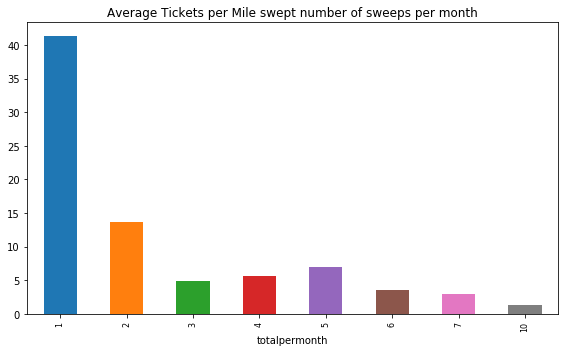

In [84]:
ticks.groupby(by = 'totalpermonth')['success_rate'].mean().plot(kind = 'bar')
plt.title('Average Tickets per Mile swept number of sweeps per month')

It appears out theory is true, proving that more inconsistently swept streets are more effective. Let's combine by StreetID so we can get streets that are MWF, etc. 

In [85]:
by_street = ticks.groupby('lineid')[['totalpermonth', 'distance', 'TicketNumber']].sum()

In [86]:
by_street['miles_sweeped_year'] = by_street['totalpermonth'] * 12 * by_street['distance']
by_street['success_rate'] = by_street['TicketNumber'] / by_street['miles_sweeped_year'] 

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


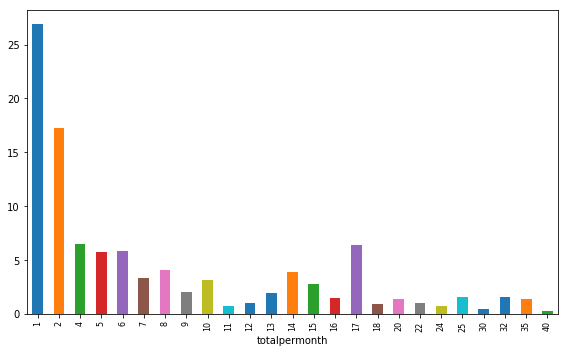

In [87]:
by_street.groupby('totalpermonth')['success_rate'].mean().plot(kind = 'bar')

Some streets are every single day of the week, which would show up as 7X5 =35 days here. In reality thats not possible. 
However, our theory holds that less frequent street cleaning is much more effective at getting tickets per mile swept, assuming their goal isn't actually related to street cleanliness. 

Text(0.5, 1.0, 'Average Tickets per Mile Swept by Hour of Day Start')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


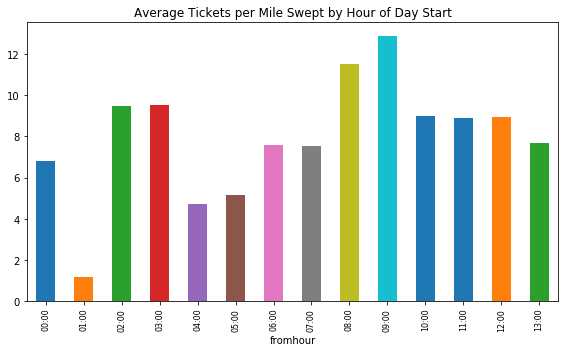

In [88]:
by_hour = ticks.groupby(by = 'fromhour')['success_rate'].mean().plot(kind = 'bar')
plt.title('Average Tickets per Mile Swept by Hour of Day Start')

The other theory is incorrect, morning sweeping is the most effective.

Text(0.5, 1.0, 'Average Tickets per Mile swept by Day of Week')

/home/colin/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


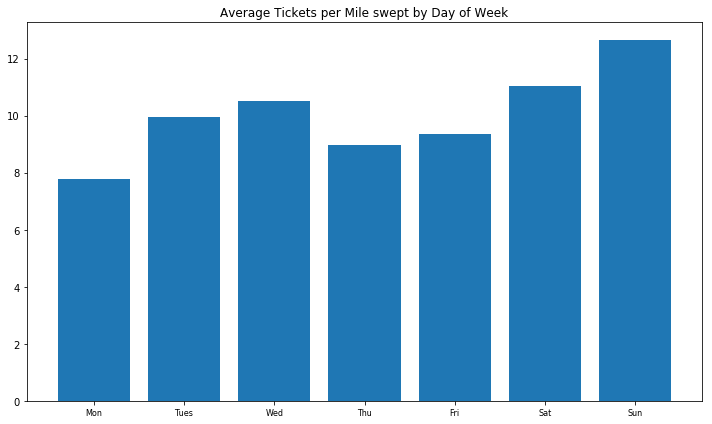

In [89]:
plt.figure(figsize = (10,6))
daydict = {'Mon':1, 'Tues':2, 'Wed' :3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7}
df = ticks.groupby(by = 'weekday',as_index = False)['success_rate'].mean()
df['daynum'] = df['weekday'].map(daydict)
df.sort_values(by = 'daynum', inplace = True)
df.drop(columns = 'daynum', inplace = True)
plt.bar(x = df['weekday'],height = df['success_rate'])
plt.title('Average Tickets per Mile swept by Day of Week')

Weekends look to catch people off guard. 